# 使用信号处理函数-argrelextrema

In [3]:
import numpy as np
from alpha.notebook import *
from scipy.signal import argrelextrema
import numpy as np
pd.options.display.max_rows = 999
from alpha.core.rsi_stats import rsi30, rsiday
from alpha.ml.index_sh_pv import IndexShPeakValleys

await init_notebook()

shday = await get_bars("000001.XSHG", 100, '1d', '2021-11-5 15:00')
shmin = await get_bars("000001.XSHG", 220, '30m', '2021-11-05 15:00')

# 指数30分钟拐头报警

In [ ]:
minclose = shmin["close"]
minframe = shmin["frame"]
ma = moving_average(minclose, 5)

# align frame with ma
close = close[4:]
frame = frame[4:]
bars = sh[4:]


local_ma = argrelextrema(ma, np.greater, order=5)[0]
local_mi = argrelextrema(ma, np.less, order=5)[0]

plt.plot(ma)
plt.plot(local_ma, ma[local_ma], 'gv')
plt.plot(local_mi, ma[local_mi], 'r^')
for i in local_ma:
    plt.text(i, ma[i], f"{str(frame[i])[5:13]}_{i}")    
for i in local_mi:
    plt.text(i, ma[i], f"{str(frame[i])[5:13]}_{i}")

# 机器学习模型

## 数据标注

In [ ]:
sh = await get_bars("000001.XSHG", 12000, '30m', end="2011-11-05 15:00")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot()

for i in range(100, len(sh)-1, 100):
    bars = sh[i-100:i]
    peaks, valleys = peaks_and_valleys(bars["close"], 5e-3, width=8)
        
    ax.plot(bars["close"])
    ax.scatter(peaks, bars["close"][peaks], color='blue')
    ax.scatter(valleys, bars["close"][valleys], color='red')

    fig.savefig(f"/tmp/pv/{i-100:04d}.png")
    ax.cla()

## 训练

In [ ]:
import random
features = []

from sklearn.model_selection import train_test_split

for i in peaks:
    if i < 100 or i == 12000-1:
        continue
        
    feature, desc = reversal_features("000001.XSHG", shmin_12000[i-99:i+1], FrameType.MIN30, peak_altitude=1e-3)
    features.append([*feature, 0, i])
    
for i in valleys:
    if i < 100 or i == 12000-1:
        continue
        
    feature, desc = reversal_features("000001.XSHG", shmin_12000[i-99:i+1], FrameType.MIN30, peak_altitude=1e-3)
    features.append([*feature, 1, i])
    
excluded = set(peaks)
excluded.update(valleys)

for i in random.sample(range(100, 9999), 1000):
    if i not in excluded:
        feature, desc = reversal_features("000001.XSHG", shmin_12000[i-99:i+1], FrameType.MIN30, peak_altitude=1e-3)
        features.append([*feature, 2, i])
        
features = np.array(features)
total = len(features)
train_indices = random.sample([i for i in range(total)], int(0.8 * total ))
test_indices = list(set(np.arange(total)) - set(train_indices))

X_train = features[train_indices][:,0:-2]
y_train = features[train_indices][:,-2].astype('i4')
meta_train = features[train_indices][:,-1].astype('i4')

X_test = features[test_indices][:,0:-2]
y_test = features[test_indices][:,-2].astype('i4')
meta_test = features[test_indices][:,-1].astype('i4')
print(X_train[0])
print(y_train[0])

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


model = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 1),
    "max_depth": randint(2, 6),
    "n_estimators": randint(80, 150),
    "subsample": uniform(0.6, 0.4),
}

search = RandomizedSearchCV(
    model,
    param_distributions=params,
    random_state=78,
    n_iter=100,
    cv=3,
    verbose=1,
    n_jobs=4,
    return_train_score=True,
    refit=True,
)

search.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
model = search.best_estimator_
preds = model.predict(X_test)
report = classification_report(y_test, preds)
print(report)

for i in range(len(y_test)):
    if i == 20:
        break
    if y_test[i] != preds[i]:
        pos = int(meta_test[i])
        
        cs = Candlestick({'30m': [5, 10, 20, 30]}, n_plot_bars=60)
        bars = shmin_12000[pos-50:pos+10]

        vec, desc = reversal_features("000001.XSHG", bars[:-9], FrameType.MIN30, peak_altitude=1e-3)
        
        features = [f"{d}: {v:.2f}" for d, v in zip(desc, vec)]
        plt.text(0, 0, "\n".join(features))
        
        cs.plot_bars(bars, title = f"True: {y_test[i]}/ Pred: {preds[i]}", signals=[(50, 'x', 'r')])


# revisions
v1: 
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       158
           1       0.68      0.76      0.72       134
           2       0.57      0.44      0.50       177

    accuracy                           0.66       469
   macro avg       0.65      0.67      0.66       469
weighted avg       0.65      0.66      0.65       469


[x] v2: parab_vx 取值范围过宽，可能导致收敛困难，应该限制在-win:win之间。

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       144
           1       0.71      0.85      0.77       143
           2       0.62      0.42      0.50       185

    accuracy                           0.66       472
   macro avg       0.66      0.68      0.66       472
weighted avg       0.65      0.66      0.65       472


# 模型实测

In [ ]:
from alpha.ml.index_sh_pv import IndexShPeakValleys
shpv30m = IndexShPeakValleys(version="v1", inference_mode=True)

In [ ]:
start = arrow.get("2021-11-09 10:00")
end = arrow.get("2021-11-22 15:00")

for tm in tf.get_frames(start, end, FrameType.MIN30):
    tm = tf.int2time(tm)
    
    bars = await get_bars("000001.XSHG", 100, '30m', tm)
    print(tm, shpv30m.predict(bars))

# 手工规则（30分钟）
1. 利亚德2021年11月25日15：00
2. 沪指2021年11月25日15：00
3. 万顺新材11月24日13：30 （5周期内收盘价未创新高，当前低于ma5?)
4. 最近10周期内，均线空多头排列情况
5. 最近股价与均线关系

In [ ]:
shpv = IndexShPeakValleys(0.1)
sh = await get_bars("000001.XSHG", 12000, '30m', end="2011-11-05 15:00")

In [ ]:
def plot(i):
    i = i * 100
    bars = sh[i-100:i]
    peaks, valleys = peaks_and_valleys(bars["close"], 5e-3, width=8)


    signals = []
    for i in peaks:
        signals.append((i, f"{i}", "b"))
        
    for i in valleys:
        signals.append((i, f"{i}", "b"))
        
    cs = Candlestick({"30m":[5, 10, 20, 30]}, n_plot_bars=100, font_size=16)
    cs.plot_bars(bars, signals=signals)

In [ ]:
plot(1)

In [ ]:
magic_number(bars[0])

In [37]:
bars = await get_bars("300057.XSHE", 10, '30m', end='2021-11-29 10:30')

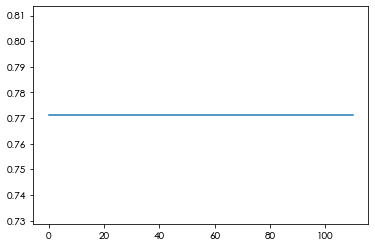

In [38]:
ma = moving_average(bars["close"], 120)
plt.plot(ma)

In [40]:
bars

array([(datetime.datetime(2021, 11, 26, 10, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.21, 9.49, 9.05, 9.19, 7044814., 64994680.32, 2.62),
       (datetime.datetime(2021, 11, 26, 10, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.19, 9.49, 9.18, 9.28, 4372366., 40911452.16, 2.62),
       (datetime.datetime(2021, 11, 26, 11, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.28, 9.35, 9.23, 9.31, 1356980., 12590114.7 , 2.62),
       (datetime.datetime(2021, 11, 26, 11, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.31, 9.35, 9.28, 9.31,  778616.,  7256800.64, 2.62),
       (datetime.datetime(2021, 11, 26, 13, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.31, 9.34, 9.23, 9.23,  964491.,  8946507.39, 2.62),
       (datetime.datetime(2021, 11, 26, 14, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 9.23, 9.4 , 9.22, 9.33, 1650800., 15368956.  , 2.62),
       (datetime.datetime(2021, 11, 26, 14, 30, tzinfo=tzfile('/usr/share

In [42]:
init_jq()
jq_get_bars("300057.XSHE", 10, '30m', end='2021-11-29 10:30')

auth success 


array([(datetime.datetime(2021, 11, 26, 10, 0), 9.21, 9.49, 9.05, 9.19, 7044900.),
       (datetime.datetime(2021, 11, 26, 10, 30), 9.19, 9.49, 9.18, 9.28, 4372400.),
       (datetime.datetime(2021, 11, 26, 11, 0), 9.28, 9.35, 9.23, 9.31, 1357000.),
       (datetime.datetime(2021, 11, 26, 11, 30), 9.31, 9.35, 9.28, 9.31,  778600.),
       (datetime.datetime(2021, 11, 26, 13, 30), 9.31, 9.34, 9.23, 9.23,  964500.),
       (datetime.datetime(2021, 11, 26, 14, 0), 9.23, 9.4 , 9.22, 9.33, 1650800.),
       (datetime.datetime(2021, 11, 26, 14, 30), 9.32, 9.36, 9.31, 9.31,  956700.),
       (datetime.datetime(2021, 11, 26, 15, 0), 9.33, 9.33, 9.19, 9.24, 2376700.),
       (datetime.datetime(2021, 11, 29, 10, 0), 9.09, 9.32, 9.09, 9.16, 4629655.),
       (datetime.datetime(2021, 11, 29, 10, 30), 9.16, 9.18, 9.06, 9.16, 2954285.)],
      dtype=(numpy.record, [('frame', 'O'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('volume', '<f8')]))